In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn import metrics
import os
from models import resnet_50_classify
import matplotlib.pyplot as plt
from data_processing import load_split_train_test


In [2]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    X.requires_grad_()

    saliency = None
    
    scores = model(X)

    correct_scores = scores.gather(1, y.view(-1, 1)).squeeze()

    dscores = torch.ones(correct_scores.shape)
    correct_scores.backward(dscores)

    dx = X.grad.data 

    dx = dx.abs()
    
    saliency, indicies = torch.max(dx, dim = 1)
    
    return saliency

In [3]:
def saliency_driver(trainloader, testloader, path):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    model = resnet_50_classify(0.2)
    model.load_state_dict(torch.load(path, map_location=map_location)) # missing keys if True
    model.eval()
    model.to(device)

    
    for param in model.parameters():
        param.requires_grad = False
    

    sample_images_test = None
    sample_labels_test = None
    for test_images, test_labels in testloader:  
        sample_images_test = test_images[0:3] # shape: (5, 3, H, W)
        sample_labels_test = test_labels[0:3]
        break
        
    print("Sample test images shape: ", sample_images_test.shape)
    print("Sample test labels shape: ", sample_labels_test.shape)
    
    sample_images_train = None
    sample_labels_train = None
    for train_images, train_labels in trainloader:  
        sample_images_train = train_images[0:3] # shape: (5, 3, H, W)
        sample_labels_train = train_labels[0:3]
        break
        
    print("Sample train images shape: ", sample_images_train.shape)
    print("Sample train labels shape: ", sample_labels_train.shape)
    
    sample_images = torch.cat((sample_images_train, sample_images_test), dim=0)
    sample_labels = torch.cat((sample_labels_train, sample_labels_test), dim=0)
        
    print("Sample images shape: ", sample_images.shape)
    print("Sample labels shape: ", sample_labels.shape)
    
    saliency = compute_saliency_maps(sample_images, sample_labels, model)
    # saliency: (N, H, W)
    
    show_saliency_maps(sample_images, saliency)


In [22]:
def show_saliency_maps(X, saliency):
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    
    saliency = saliency.numpy()
    N = X.shape[0]
    X = X.detach()
    if not os.path.isdir("saliency_maps_driver_sep"):
        os.mkdir("saliency_maps_driver_sep")
    for i in range(N):
        plt.subplot(2, N, i + 1)
        img = X[i].permute(1,2,0)
        print(img.shape)
        plt.imshow(img)
#         plt.imsave("Orig_Img_" + str(i) + ".png", img)
        plt.axis('off')
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
#         plt.imsave("Sal_Map_" + str(i) + ".png", saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(20, 10)
    plt.show()

Performing Data Augmentation
Original Dataset Size: 18344
Augmented Dataset Size: 18344
cpu
Sample test images shape:  torch.Size([3, 3, 224, 224])
Sample test labels shape:  torch.Size([3])
Sample train images shape:  torch.Size([3, 3, 224, 224])
Sample train labels shape:  torch.Size([3])
Sample images shape:  torch.Size([6, 3, 224, 224])
Sample labels shape:  torch.Size([6])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


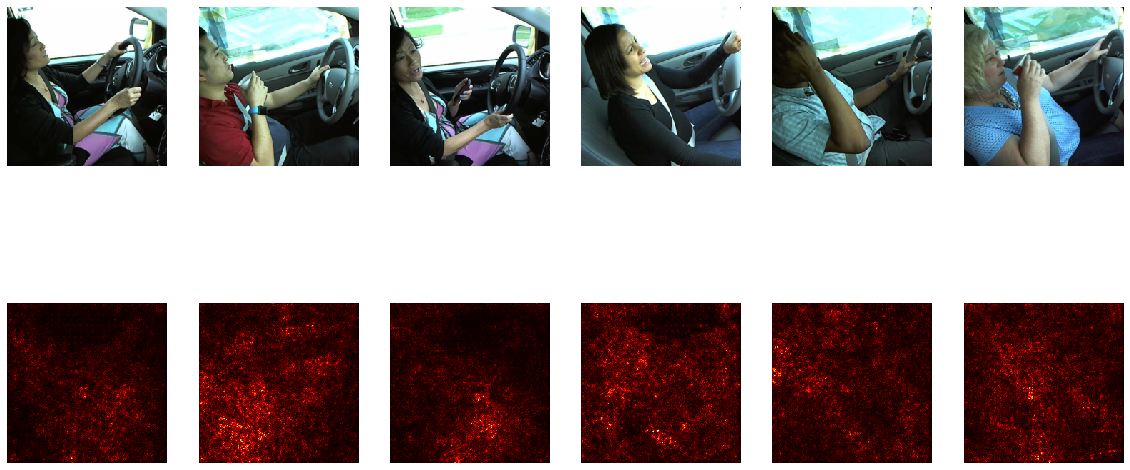

In [23]:
IMGS_DIR = "imgs_out"
trainloader, testloader  = load_split_train_test(IMGS_DIR, False,False, False, valid_size = .2)
MODELPATH = "baseline_resnet50_driver_sep_only.bin"
saliency_driver(trainloader, testloader, MODELPATH)